In [10]:
import sdepy
import numpy as np

@sdepy.integrate
def my_process(t, x, theta=1., k=1., sigma=1.):
    return {'dt': k*(theta - x), 'dw': sigma}

x = my_process(x0=1, paths=100*1000, steps=100)


In [14]:
timeline = np.linspace(0., 1., 5)
x(timeline)
timeline

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [40]:
ALPHAVANTAGE_API = 'S09O7OIWCQWSMDGQ'
import requests
import json
import pandas as pd

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=IBM&month=2009-01&interval=1min&apikey={ALPHAVANTAGE_API}'
r = requests.get(url)
data = r.json()["Time Series (Daily)"]

df = pd.DataFrame([data[elem] for elem in data])
df.rename(columns={
    '1. open': 'Open',
    '2. high': 'High',
    '3. low': 'Low',
    '4. close': 'Close',
    '5. volume': 'Volume'
}, inplace=True)
df['Open'] = df['Open'].astype(float)
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)
df['Close'] = df['Close'].astype(float)
df['Volume'] = df['Volume'].astype(int)

df['Date'] = data.keys()
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
#with open('data.json', 'w') as f:
#    json.dump(data, f)

In [38]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2024-09-06,202.38,204.100,199.335,200.74,3304491
2024-09-05,204.08,205.950,200.960,202.59,3229345
2024-09-04,200.76,204.360,200.500,204.11,3111332
2024-09-03,201.91,204.720,200.210,201.28,3874697
2024-08-30,199.11,202.170,198.730,202.13,4750999
...,...,...,...,...,...
2024-04-22,182.45,183.315,180.450,181.90,3076451
2024-04-19,182.43,182.800,180.570,181.58,3037990
2024-04-18,182.35,183.460,180.170,181.47,2886733


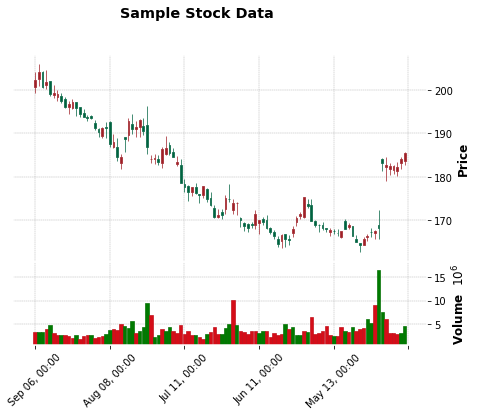

In [39]:
import mplfinance as mpf
mpf.plot(df, type='candle', style='charles', volume=True, title='Sample Stock Data', ylabel='Price')
